In [1]:
import dlib
import os
import shutil
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, c, h, w].
        Returns:
            a float tensor with shape [batch_size, c*h*w].
        """

        x = x.transpose(3, 2).contiguous()

        return x.view(x.size(0), -1)

class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 32, 3, 1)),
            ('prelu1', nn.PReLU(32)),
            ('pool1', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv2', nn.Conv2d(32, 64, 3, 1)),
            ('prelu2', nn.PReLU(64)),
            ('pool2', nn.MaxPool2d(3, 2, ceil_mode=True)),

            ('conv3', nn.Conv2d(64, 64, 3, 1)),
            ('prelu3', nn.PReLU(64)),
            ('pool3', nn.MaxPool2d(2, 2, ceil_mode=True)),

            ('conv4', nn.Conv2d(64, 128, 2, 1)),
            ('prelu4', nn.PReLU(128)),

            ('flatten', Flatten()),
            ('conv5', nn.Linear(1152, 256)),
            ('drop5', nn.Dropout(0.25)),
            ('prelu5', nn.PReLU(256)),
        ]))

        # Output layer with 136 features
        self.output_layer = nn.Linear(256, 136)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [batch_size, 3, h, w].
        Returns:
            landmarks: a float tensor with shape [batch_size, 136].
        """
        x = self.features(x)
        landmarks = self.output_layer(x)
        return landmarks

class LandmarksDataset(Dataset):
    def __init__(self, root_dir, landmarks_file, transform=None):
        self.root_dir = root_dir
        self.landmarks_file = landmarks_file
        self.transform = transform

        # Load landmarks from file
        self.landmarks = self._load_landmarks()

    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        img_name, landmarks = self.landmarks[idx]
        landmarks = np.array(landmarks).reshape(-1, 2)

        # Load image
        img_path = os.path.join(self.root_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms.ToPILImage()(image)
        # Apply transformations
        if self.transform:
            # if torch.rand(1) < 0.5:
            #     image = cv2.flip(np.array(image), 1)
            #     image = transforms.ToPILImage()(image)
            #     mask = (landmarks[:, 0] != -1)
            #     landmarks[mask, 0] = 1 - landmarks[mask, 0]
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(image)

        # Convert landmarks to tensor
        landmarks = torch.flatten(torch.tensor(landmarks, dtype=torch.float32))

        return image, landmarks

    def _load_landmarks(self):
        landmarks = []
        with open(self.landmarks_file, 'r') as f:
            for line in f:
                data = line.strip().split()
                img_name = data[0]
                landmarks_data = [float(coord) for coord in data[1:]]
                landmarks.append((img_name, landmarks_data))
        return landmarks

# Define color transformations and normalization
color_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
])

class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, predicted_landmarks, target_landmarks):
        # Mask for elements with value -1
        mask = (target_landmarks != -1).float()

        # Compute squared error only for non-masked elements
        loss = torch.sum((predicted_landmarks - target_landmarks)**2 * mask) / torch.sum(mask)

        return loss

def visualize_batch(images, landmarks):
    num_samples = images.shape[0]
    fig, axes = plt.subplots(nrows=num_samples, ncols=1, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and permute dimensions
        landmarks_np = landmarks[i].numpy().reshape(-1, 2)  # Reshape landmarks to separate x and y coordinates
        landmarks_np = landmarks_np * 48 # de-normalization

        # Plot image
        axes[i].imshow(image)
        axes[i].axis('off')

        # Plot landmarks
        axes[i].scatter(landmarks_np[:, 0], landmarks_np[:, 1], c='r', marker='o')
        axes[i].set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()

In [3]:
root_dir = 'cropped_faces'
landmarks_file = 'landmarks.txt'
dataset = LandmarksDataset(root_dir, landmarks_file, transform=color_transform)
dataloader_train = DataLoader(dataset, batch_size=32, shuffle=True)

root_dir = 'cropped_faces_test'
landmarks_file = 'landmarks_test.txt'
dataset = LandmarksDataset(root_dir, landmarks_file, transform=None)
dataloader_test = DataLoader(dataset, batch_size=1024, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

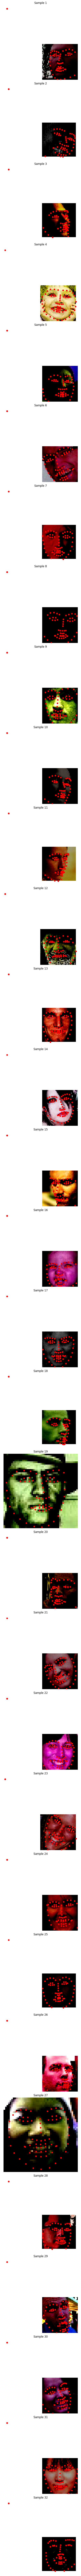

In [4]:
for batch in dataloader_train:
    images, landmarks = batch
    visualize_batch(images, landmarks)
    break  # Only visualize the first batch

In [6]:
# Define the model
model = ONet()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Define the loss function
# criterion = nn.MSELoss()
criterion = CustomMSELoss()

# Number of epochs
num_epochs = 100

# Initialize variables to track best test loss and corresponding model state
best_test_loss = float('inf')
best_model_state = None

# Lists to store training and testing losses
train_losses = []
test_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    running_loss = 0.0
    for images, landmarks in dataloader_train:
        # Move data to GPU if available
        images, landmarks = images.to(device), landmarks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, landmarks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    train_loss = running_loss / len(dataloader_train)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

    # Testing
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, landmarks in dataloader_test:
            # Move data to GPU if available
            images, landmarks = images.to(device), landmarks.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, landmarks).item()

    test_loss /= len(dataloader_test)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}')

    # Save the model if test loss improves
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model, 'best_model.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Training Loss: 0.028249494818060897
Epoch 1/100, Test Loss: 0.006117945536971092
Epoch 2/100, Training Loss: 0.007523016228752081
Epoch 2/100, Test Loss: 0.0036483274307101965
Epoch 3/100, Training Loss: 0.005606960303821536
Epoch 3/100, Test Loss: 0.0027063374873250723
Epoch 4/100, Training Loss: 0.004588219709694386
Epoch 4/100, Test Loss: 0.00263281911611557
Epoch 5/100, Training Loss: 0.003941813899680626
Epoch 5/100, Test Loss: 0.0021605677902698517
Epoch 6/100, Training Loss: 0.003551123676778272
Epoch 6/100, Test Loss: 0.0019858372397720814
Epoch 7/100, Training Loss: 0.0032212263449679975
Epoch 7/100, Test Loss: 0.002037924248725176
Epoch 8/100, Training Loss: 0.002967863861298145
Epoch 8/100, Test Loss: 0.001819369732402265
Epoch 9/100, Training Loss: 0.0028972762734304335
Epoch 9/100, Test Loss: 0.0016738937702029943
Epoch 10/100, Training Loss: 0.002600818511835018
Epoch 10/100, Test Loss: 0.001766845933161676
Epoch 11/100, Training Loss: 0.0025829780624832873
E

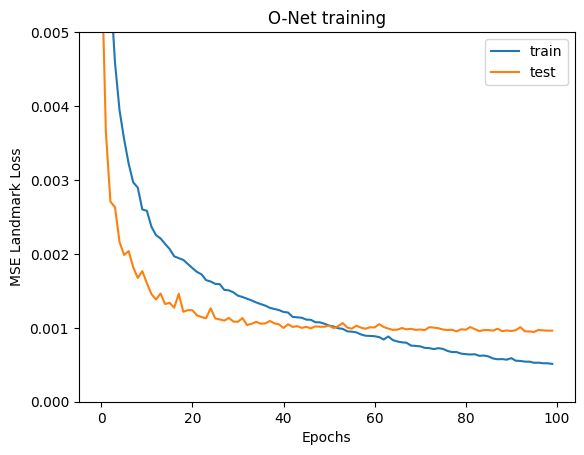

In [7]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.ylim(0, 0.005)
plt.ylabel('MSE Landmark Loss')
plt.xlabel('Epochs')
plt.title('O-Net training')
plt.legend()

In [8]:
model = torch.load('best_model.pt')

In [9]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, landmarks in dataloader_test:
        # Move data to GPU if available
        images, landmarks = images.to(device), landmarks.to(device)

        outputs = model(images)
        test_loss += criterion(outputs, landmarks).item()

test_loss /= len(dataloader_test)
print(test_loss)

0.000943161896429956


In [13]:
def visualize_face_with_landmarks(image, landmarks):
    # Plot the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Plot the landmarks
    for landmark in landmarks:
        x, y = landmark
        if x > 0 and y > 0:
            plt.scatter(x * image.shape[1], y * image.shape[0], color='red', s=5)
    
    plt.axis('off')
    plt.show()

In [29]:
image_id = 9

image_np = np.array(np.transpose(images[image_id].cpu(), (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


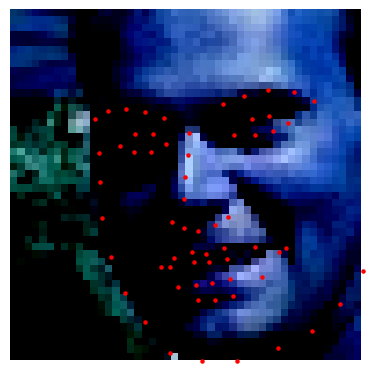

In [30]:
visualize_face_with_landmarks(image_np, landmarks[image_id].cpu().numpy().reshape(-1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


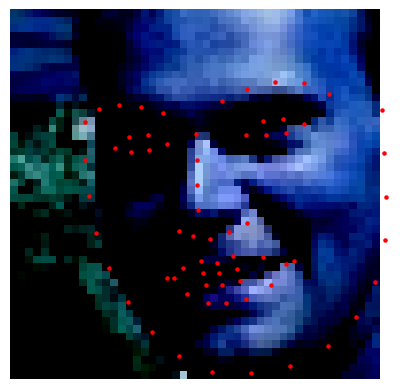

In [31]:
visualize_face_with_landmarks(image_np, outputs[image_id].cpu().numpy().reshape(-1, 2))